In [1]:
# Importing libraries

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-08-19 22:06:46.648781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-08-19 22:06:46.674330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-19 22:06:46.674701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-08-19 22:06:46.674884: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-08-19 22:06:46.676132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-19 22:06:46.677297: I tensorflow/st

If uncommented it will print all the log information about where the tensorflow operations were performed, in the CPU or the GPU

In [4]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

# Loading the train data set

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
def my_crop(img, start_y, start_x, desired_height, desired_width):
  if K.image_data_format() == 'channels_last':
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    dy = desired_height #input desired output size
    dx = desired_width #input desired output size
    # start_y = (height-dy)//2
    # start_x = (width-dx)//2
    return img[start_y:start_y+dy, start_x:(dx+start_x), :]
  else:
      assert img.shape[0] == 3
      dy = desired_height #input desired output size
      dx = desired_width #input desired output size
      # start_y = (height-dy)//2
      # start_x = (width-dx)//2
      return img[:,start_y:start_y + dy, start_x:(dx + start_x)]

def crop_augmented_generator(batches, start_y, start_x, crop_height, crop_width):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
    
      if K.image_data_format() == 'channels_last':
        # print("type of batch_x: ", type(batch_x))
        # print("type of batch_y: ", type(batch_y))
        # print("len of batch_x: ", len(batch_x))

        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], crop_height, crop_width, 3))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], crop_height, crop_width, 3))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], crop_height, crop_width, 3))
      else:
        # Either batch_x or batch_y could be augmented or original
        batch_crops_input_x = np.zeros((batch_x[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_x = np.zeros((batch_x[1].shape[0], 3, crop_height, crop_width))

        batch_crops_input_y = np.zeros((batch_y[0].shape[0], 3, crop_height, crop_width))
        batch_crops_target_y = np.zeros((batch_y[1].shape[0], 3, crop_height, crop_width))

      for i in range(batch_x[0].shape[0]):
        #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
        batch_crops_input_x[i] = my_crop(batch_x[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_x[i] = my_crop(batch_x[1][i], start_y, start_x, crop_height, crop_width)

        batch_crops_input_y[i] = my_crop(batch_y[0][i], start_y, start_x, crop_height, crop_width)
        batch_crops_target_y[i] = my_crop(batch_y[1][i], start_y, start_x, crop_height, crop_width)
      
      # print(type(batch_crops_input_x))
      batch_crops_x = (batch_crops_input_x, batch_crops_target_x)
      batch_crops_y = (batch_crops_input_y, batch_crops_target_y)

      yield (batch_crops_x, batch_crops_y)

  
    
def crop_generator(batches, start_y, start_x, crop_height, crop_width, flag=0):
    '''
    Take as input a Keras ImageGen (Iterator) and generate
    crops from the image batches generated by the original iterator
    '''
    # print("I'm in the crop_generataor function")
    while True:
      batch_x, batch_y = next(batches)  # In batch_x there are the images, in batch_y there are the labels
    #   print("hello")
    #   print('the shape of tensor batch_x is:', batch_x.shape)
    #   print('batch_y is:', batch_y)
      if flag==0:
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
          batch_crops_y = np.zeros((batch_y.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
          batch_crops_y = np.zeros((batch_y.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
            batch_crops_y[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)
        yield (batch_crops, batch_crops_y)
      else: 
        if K.image_data_format() == 'channels_last':
          batch_crops = np.zeros((batch_x.shape[0], crop_height, crop_width, 3))
        else:
          batch_crops = np.zeros((batch_x.shape[0], 3, crop_height, crop_width))
        for i in range(batch_x.shape[0]):
          #   print("THe shape of a single image before the cropping is: ", batch_x[i].shape)
            batch_crops[i] = my_crop(batch_x[i], start_y, start_x, crop_height, crop_width)

        yield (batch_crops, batch_y)
         

In [6]:
# batch_size = 64
batch_size = 10
train_datagen = ImageDataGenerator(rescale=1./255,
                                    brightness_range=[0.88,1.0]) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals and changing the brightness


original_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",          # For work laptop
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )

# Generate original images from the original data directory
original_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Positive/",
    batch_size=batch_size,
    shuffle = False,
    class_mode='input')

# Combine the generators using the `keras.preprocessing.image.Iterator` class
combined_generator = zip(train_generator, original_generator)

Found 295 images belonging to 1 classes.
Found 295 images belonging to 1 classes.


In [7]:
validation_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 20 images belonging to 1 classes.


In [8]:
anomaly_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 10 images belonging to 1 classes.


In [9]:
test_set_generator = original_datagen.flow_from_directory(
    "../../Images/june5Night/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Creating the cropped images

In [10]:
HEIGHT = 160
WIDTH = 128

In [11]:
train_crops = crop_augmented_generator(combined_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
val_crops = crop_generator(validation_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
anomaly_crops = crop_generator(anomaly_generator, 65, 69, HEIGHT,WIDTH)      # top, left, height, width
test_crops = crop_generator(test_set_generator, 65, 69, HEIGHT,WIDTH,1)      # top, left, height, width

Here we make sure that both of the returned elements of the cropped generator, that is "imgaes_in_batch" and "imgaes_in_batch2", are indeed cropped images.

In [12]:
images_in_batch, images_in_batch2 = next(train_crops)


In [13]:
batch_input_images1 = images_in_batch[0]
batch_expected_images1 = images_in_batch[1]
print(batch_input_images1.shape)
print(batch_expected_images1.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


In [14]:
batch_input_images2 = images_in_batch2[0]
batch_expected_images2 = images_in_batch2[1]
print(batch_input_images2.shape)
print(batch_expected_images2.shape)

(10, 160, 128, 3)
(10, 160, 128, 3)


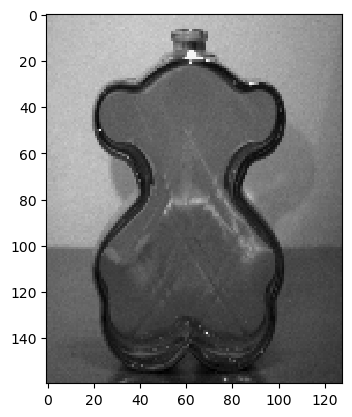

In [15]:
single_img_batch1 = batch_input_images1[0]
plt.imshow(single_img_batch1)

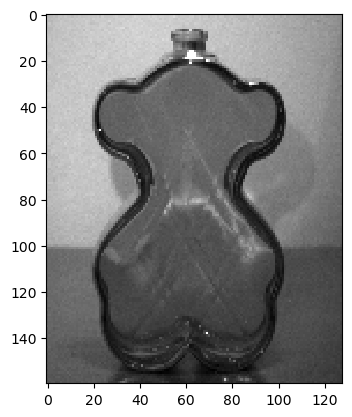

In [16]:
single_img_batch2 = batch_input_images2[0]
plt.imshow(single_img_batch2)

# Building the model Autoencoder model

In [17]:
latent_dim = 40  # Number of latent dimension parameters

input_img = Input(shape=(HEIGHT, WIDTH, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(80, activation='relu')(x)        # Activation function is supposed to be none, i.e the output is the same as the input

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

2023-08-19 22:06:47.246891: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-08-19 22:06:47.273581: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-08-19 22:06:47.273960: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f98c0001560 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-19 22:06:47.273975: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-19 22:06:47.356042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-19 22:06:47.356436: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4e478b0 initialized for platform CUDA (this does not guarantee that XLA will

(None, 10, 8, 1)
(None, 40)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (Non

In [18]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(10*8*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(320, activation='sigmoid', name="original_decoder")(x)
x = Reshape((10,8,4),input_shape=(320,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)
x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 320)               13120     
_________________________________________________________________
original_decoder (Dense)     (None, 320)               102720    
_________________________________________________________________
reshape (Reshape)            (None, 10, 8, 4)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 8, 3)          111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 20, 16, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 16, 3)         84  

In [19]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mean_squared_error')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0   

# Training the model

In [20]:
# # from tensorflow.keras.callbacks import EarlyStopping
# # run the modelvalidat
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=5, mode='auto')
# history = ae.fit(train_crops, epochs=300, steps_per_epoch=len(train_generator)*2, validation_data=val_crops, validation_steps =len(validation_generator),  verbose=1, shuffle = True)

In [21]:

# # Get the training and validation loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Plot the training and validation loss
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


Saving the train and validation history data

In [22]:
# # open file
# with open('txtFilesAutoencoderBottles6/TrainingLoss.txt', 'w+') as g:
#     # write elements of list
#     for items in train_loss:
#         g.write('%s\n' %items)
#     print("train_loss written successfully")
# # close the file
# g.close() 

# # open file
# with open('txtFilesAutoencoderBottles6/ValidationLoss.txt', 'w+') as g:
#     # write elements of list
#     for items in val_loss:
#         g.write('%s\n' %items)
#     print("val_loss written successfully")
# # close the file
# g.close()


LOading the train and validation history data

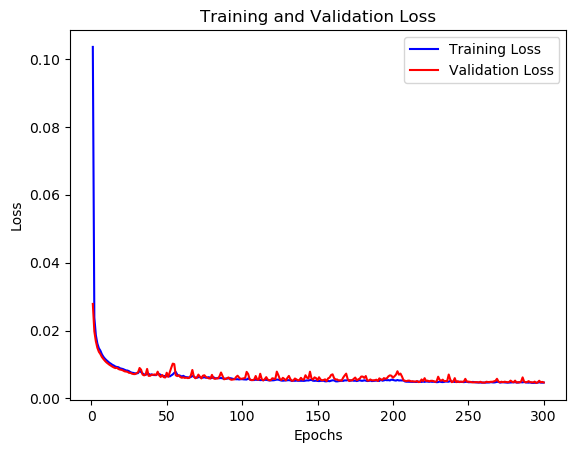

In [23]:
# Load data from the text file
with open("txtFilesAutoencoderBottles6/TrainingLoss.txt", "r") as file:
    train_loss_data = [float(line.strip()) for line in file]

# Load data from the text file
with open("txtFilesAutoencoderBottles6/ValidationLoss.txt", "r") as file:
    val_loss_data = [float(line.strip()) for line in file]

# Plot the training and validation loss
epochs = range(1, len(train_loss_data) + 1)
plt.plot(epochs, train_loss_data, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_data, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
filepath = "models/Bottles6_playground"

In [25]:
# ae.save(f"{filepath}")

Loading the model that was previously saved


In [26]:
# VAE model statement
model = Model(input_img,z_decoded)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 16, 16)        0   

In [27]:
model = keras.models.load_model(f'{filepath}')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


# Quantifying the reconstruction error using "evaluate_generator()" function

Performing the computation of the reconstruction error of all the images in the training dataset. Computing the MSE of each image with its reconstructed version.

In [28]:

training_error = model.evaluate_generator(train_crops, steps=len(train_generator)*2)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

Instructions for updating:
Please use Model.evaluate, which supports generators.


2023-08-19 22:06:49.838057: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-19 22:06:50.039711: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


Recon. error for the training (non-anomaly) data is:  0.004599393345415592


# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [29]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [30]:
total_rec_error = []
for i in range(len(train_generator)):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_in_batch2 = next(train_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    batch_input_images1 = images_in_batch[0]
    total_rec_error.append(calc_recon_error(batch_input_images1))
    batch_input_images2 = images_in_batch2[0]
    total_rec_error.append(calc_recon_error(batch_input_images2))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")


1/1 [==============================] - 0s 592us/step - loss: 0.0056
The list of rec. error contains  60 batches of rec. errors


Above we can see, that it contains 60 batches and almost all of them includes 10 elements. Recall that the total number of images of the training dataset was 295. Hence in total we should have 295*2=590 error values. Let's convert it into a 590-length list.

In [31]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

590


In [32]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.0068161893312393106
The standard deviation of the errors list is:  0.002247349706283888
The min value of the errors list is:  0.004731549881398678
The max value of the errors list is:  0.020867813378572464


Above it can be seen that computing the model.evaluate_generator() function does NOT output the same as computing the error of each image one by one. We will use this last approach, the one by one error computation.

# Comparing with a custom created MSE function

In [33]:
def mse(image1, image2):
    squared_diff = np.square(image1 - image2)
    mse_value = np.mean(squared_diff)
    return mse_value

In [34]:
def calc_recon_error_withOwnMSE(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # print(reconstruction[0].shape)
        # print(img[0].shape)
        # image_permuted1 = reconstruction[0].permute(1, 2, 0) 
        # image_permuted2 = img[0].permute(1, 2, 0) 
        # print(image_permuted1.shape)
        # print(image_permuted2.shape)
        
        reconstruction_error = mse(img[0],reconstruction[0])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [35]:
total_rec_error = []
total_rec_error2 = []
for i in range(1):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_in_batch2 = next(train_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    
    batch_input_images1 = images_in_batch[0]
    total_rec_error.append(calc_recon_error_withOwnMSE(batch_input_images1))
    batch_input_images2 = images_in_batch2[0]
    total_rec_error.append(calc_recon_error_withOwnMSE(batch_input_images2))

    total_rec_error2.append(calc_recon_error(batch_input_images1))
    total_rec_error2.append(calc_recon_error(batch_input_images2))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")
print("The list of rec. error contains ", len(total_rec_error2), "batches of rec. errors")

1/1 [==============================] - 0s 640us/step - loss: 0.0056
The list of rec. error contains  2 batches of rec. errors
The list of rec. error contains  2 batches of rec. errors


In [36]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

total_rec_error_list2 = [item for sublist in total_rec_error2 for item in sublist]
print(len(total_rec_error_list2))

20
20


In [37]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.005248125243101754
The standard deviation of the errors list is:  0.001075651086122679
The min value of the errors list is:  0.0039970471059443576
The max value of the errors list is:  0.007466854805030381


In [38]:
na_average_recon_error = np.mean(np.array(total_rec_error_list2))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list2)) 
min_prob = np.min(total_rec_error_list2)
max_prob = np.max(total_rec_error_list2)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.006202859105542302
The standard deviation of the errors list is:  0.0014649847103773736
The min value of the errors list is:  0.004927421920001507
The max value of the errors list is:  0.010507719591259956


Comparing only one image with both approaches

In [40]:
total_rec_error = []
total_rec_error2 = []
for i in range(1):                               #This will traverse the train generator the number of batches it contains
    images_in_batch, images_in_batch2 = next(train_crops)           #As for each next step of the "train_crops" generator it exists one batch of the augmented and one batch of the orignial images, we perform twice the calc_recon_error() function
    
    batch_input_images1 = images_in_batch[0]

    for im in range(1):
        img  = batch_input_images1[im]
        img1 = img[np.newaxis, :,:,:]
        reconstruction1 = model.predict([[img1]])
        
        reconstruction_error1 = mse(img1[0],reconstruction1[0])
        print("This is the rec error found by the MSE custom function:", reconstruction_error1)
    
    for im in range(1):
        img  = batch_input_images1[im]
        img2 = img[np.newaxis, :,:,:]
        reconstruction2 = model.predict([[img2]])
        
        reconstruction_error2 = model.evaluate([img2],[reconstruction2])
        print("This is the rec error found by the evaluate() function:", reconstruction_error2)
    compareImgs = img1==img2
    compareRecs = reconstruction1==reconstruction2
    res1 =  np.all(compareImgs)
    res2 = np.all(compareRecs)

    print("This is comparisson imgs:", res1)
    print("This is comparisson recs:", res2)


This is the rec error found by the MSE custom function: 0.004655175975908163
1/1 [==============================] - 0s 574us/step - loss: 0.0000e+00
This is the rec error found by the evaluate() function: 0.0
This is comparisson imgs: True
This is comparisson recs: True


As it can be seen above, the results with the custo MSE and the evaluate function are NOT the same. These could be the cause for this difference.

Normalization or Scaling: The model.evaluate() function in Keras often expects input data to be normalized or scaled in a certain way. If your custom mse() function operates on unnormalized data, it can lead to discrepancies.

Data Type: Ensure that the data types of your images are the same in both cases. If there's a difference in data types, such as float32 vs float64, it can lead to different results due to precision differences.

Channel Ordering: Keras can have different channel ordering conventions for images (either "channels_first" or "channels_last"). If the model and your custom function are using different conventions, it can cause discrepancies.

Batch Size: The model.evaluate() function typically operates on batches of data. If you're passing a single image to it, it might internally wrap it in a batch, which could cause differences.

Preprocessing or Postprocessing: Keras might apply preprocessing or postprocessing steps to the input data before calculating the loss. Make sure your custom function takes this into account.

Finally, we can also see that the custom MSE function does not depend on the channel ordering. See below:

In [42]:
image1 = img1[0]
image2 = reconstruction1[0]
print(image1.shape)
print(image2.shape)

(160, 128, 3)
(160, 128, 3)


In [44]:
squared_diff = np.square(image1 - image2)
mse_value = np.mean(squared_diff)
print(mse_value)

0.004655175975908163


In [45]:
image_permuted1 = image1.transpose(2, 0, 1)
image_permuted2 = image2.transpose(2, 0, 1)
print(image_permuted1.shape)
print(image_permuted1.shape)

(3, 160, 128)
(3, 160, 128)


In [46]:
squared_diff = np.square(image_permuted1 - image_permuted2)
mse_value = np.mean(squared_diff)
print(mse_value)

0.004655175975908163
